Text(0.5, 1.0, '테스트')

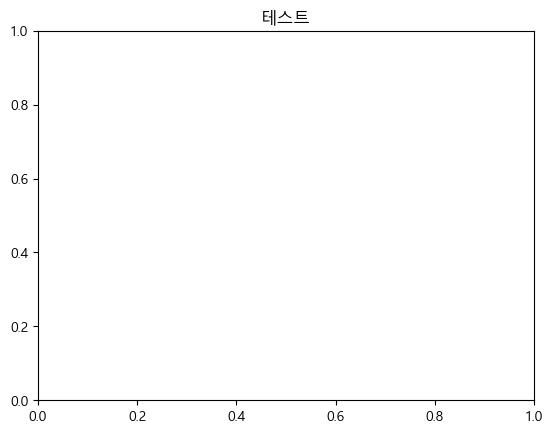

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from pyvis.network import Network
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import seaborn as sns

from matplotlib import rc
%matplotlib inline
from matplotlib import font_manager
plt.style.use('default')
f_path = "C:/windows/Fonts/malgun.ttf"
ko_font = font_manager.FontProperties(fname=f_path).get_name()
rc('font', family='Malgun Gothic')
plt.title('테스트')

In [2]:
# Data Load
#kr_sec = pd.read_csv('./kr_sec_150.csv', index_col = 0)
#ov_sec = pd.read_csv('./ov_sec_150.csv', index_col = 0)
#kr_price = pd.read_csv('./kr_price_150.csv', index_col = 0)
#ov_price = pd.read_csv('./ov_price_150.csv', index_col = 0)
#eco = pd.read_csv('./economics.csv', index_col = 0)

kr_sec = pd.read_csv('C:/Users/Administrator/Desktop/비어플_NH_last/1028/kr_sec_180.csv', index_col = 0)
ov_sec = pd.read_csv('C:/Users/Administrator/Desktop/비어플_NH_last/1028/ov_sec_180.csv', index_col = 0)
kr_price = pd.read_csv('C:/Users/Administrator/Desktop/비어플_NH_last/1028/kr_price_180.csv', index_col = 0)
ov_price = pd.read_csv('C:/Users/Administrator/Desktop/비어플_NH_last/1028/ov_price_180.csv', index_col = 0)
eco = pd.read_csv('C:/Users/Administrator/Desktop/비어플_NH_last/1028/economics.csv', index_col = 0)

eco.set_index(keys = 'Date', inplace = True)

In [3]:
# Sector별 종목명 추출
#국내
col_kr = kr_price.columns.to_list()

소재_kr = kr_sec[kr_sec['sector']=='소재']['종목명'].to_list()
col_소재_kr = [x for x in 소재_kr if x in col_kr]

정보기술_kr = kr_sec[kr_sec['sector']=='정보기술']['종목명'].to_list()
col_정보_kr = [x for x in 정보기술_kr if x in col_kr]

커뮤니케이션서비스_kr = kr_sec[kr_sec['sector']=='커뮤니케이션서비스']['종목명'].to_list()
col_커뮤_kr = [x for x in 커뮤니케이션서비스_kr if x in col_kr]

금융_kr = kr_sec[kr_sec['sector']=='금융']['종목명'].to_list()
col_금융_kr = [x for x in 금융_kr if x in col_kr]

산업재_kr = kr_sec[kr_sec['sector']=='산업재']['종목명'].to_list()
col_산업_kr = [x for x in 산업재_kr if x in col_kr]

헬스케어_kr = kr_sec[kr_sec['sector']=='헬스케어']['종목명'].to_list()
col_헬스_kr = [x for x in 헬스케어_kr if x in col_kr]

#해외
col_ov = ov_price.columns.to_list()

소재_ov = ov_sec[ov_sec['sector']=='소재']['종목명'].to_list()
col_소재_ov = [x for x in 소재_ov if x in col_ov]

정보기술_ov = ov_sec[ov_sec['sector']=='정보기술']['종목명'].to_list()
col_정보_ov = [x for x in 정보기술_ov if x in col_ov]

커뮤니케이션서비스_ov = ov_sec[ov_sec['sector']=='커뮤니케이션서비스']['종목명'].to_list()
col_커뮤_ov = [x for x in 커뮤니케이션서비스_ov if x in col_ov]

금융_ov = ov_sec[ov_sec['sector']=='금융']['종목명'].to_list()
col_금융_ov = [x for x in 금융_ov if x in col_ov]

산업재_ov = ov_sec[ov_sec['sector']=='산업재']['종목명'].to_list()
col_산업_ov = [x for x in 산업재_ov if x in col_ov]

헬스케어_ov = ov_sec[ov_sec['sector']=='헬스케어']['종목명'].to_list()
col_헬스_ov = [x for x in 헬스케어_ov if x in col_ov]

In [4]:
stock = pd.merge(kr_price, ov_price, how = 'left', left_index=True, right_index=True)
stock_eco = pd.merge(stock, eco, how = 'left', left_index=True, right_index=True)

### 상관행렬 생성

- 임계값 +-0.4 이하의 엣지는 제거

In [5]:
def generate_network(df):
    #상관행렬 생성
    stock_per = df.pct_change()
    stock_per = stock_per.iloc[1:,:]
    stock_cor = stock_per.dropna(axis = 1).corr(method = 'pearson')

    # convert matrix to list of edges and rename the columns
    edges = stock_cor.stack().reset_index()
    edges.columns = ["종목_1", "종목_2", "correlation"]

    # remove self correlations
    edges = edges.loc[edges["종목_1"] != edges["종목_2"]].copy()

    # 임계값(+-0.4) 이하 제거
    threshold = 0.4

    # 기본 무방향 그래프 생성
    Gx = nx.from_pandas_edgelist(edges, "종목_1", "종목_2", edge_attr=["correlation"])

    # list to store edges to remove
    remove = []
    # loop through edges in Gx and find correlations which are below the threshold
    for 종목_1, 종목_2 in Gx.edges():
        corr = Gx[종목_1][종목_2]["correlation"]
        # add to remove node list if abs(corr) < threshold
        if abs(corr) < threshold:
            remove.append((종목_1, 종목_2))

    # remove edges contained in the remove list
    Gx.remove_edges_from(remove)
    print(str(len(remove)) + " edges removed")
    return Gx

63138 edges removed


In [ ]:
Gx_eco = generate_network(stock_eco)

In [6]:
# 국내인지 해외인지 속성 부여하기
korea = kr_price.columns.to_list()
nasdaq = ov_price.columns.to_list()
eco_col = eco.columns.to_list()

Gx_eco.add_nodes_from(korea, shape = 'star')
Gx_eco.add_nodes_from(nasdaq, shape = 'dot')
Gx_eco.add_nodes_from(eco_col, shape = 'square')


#노드 사이즈 지정
degree_dict = dict(nx.degree(Gx_eco))
nsize = np.array([v for v in degree_dict.values()])
stock_list = np.array([v for v in degree_dict.keys()])

for i, j in enumerate(nsize):
    Gx_eco.add_node(stock_list[i], size = nsize[i]*1.1)

for n, d in Gx_eco.nodes(data=True):
    if d['shape'] =='star':
        Gx_eco.add_node(n, size = d['size']*1.1)
    elif d['shape'] == 'dot':
        Gx_eco.add_node(n, size = d['size']*0.2)
    else:
        Gx_eco.add_node(n, size = 30)

In [7]:
Gx_eco.add_nodes_from(col_소재_kr, group = 1)
Gx_eco.add_nodes_from(col_정보_kr, group = 2)
Gx_eco.add_nodes_from(col_커뮤_kr, group = 3)
Gx_eco.add_nodes_from(col_금융_kr, group = 4)
Gx_eco.add_nodes_from(col_산업_kr, group = 5)
Gx_eco.add_nodes_from(col_헬스_kr, group = 6)

Gx_eco.add_nodes_from(col_소재_ov, group = 1)
Gx_eco.add_nodes_from(col_정보_ov, group = 2)
Gx_eco.add_nodes_from(col_커뮤_ov, group = 3)
Gx_eco.add_nodes_from(col_금융_ov, group = 4)
Gx_eco.add_nodes_from(col_산업_ov, group = 5)
Gx_eco.add_nodes_from(col_헬스_ov, group = 6)

Gx_eco.add_nodes_from(eco_col, group = 7)


net = Network(notebook = True, width = '1200px', height = '1000px',
             bgcolor = '#222222', font_color = 'white')

net.repulsion(node_distance = 100, central_gravity = .01)
net.from_nx(Gx_eco)
net.show('All_Sector_Economics.html')

All_Sector_Economics.html


In [8]:
net.write_html('All_Sector_Economics.html')